# Test description

The approach of this test seeks to generically evaluate 3 types of skills required for this position:

* Handling structured objects in Python (OOP):
* Obtaining and structuring data from different online resources; for this notebook, we will use a test-web -> [http://quotes.toscrape.com/js/](http://quotes.toscrape.com/js/)
* Basic descriptive analysis of the data obtained

The answers to the questions raised in each section must be made in the cells indicated for this purpose.

# Modules required for test execution

Apart from the packages imported by default, any other can be used, such as selenium, scrapy, etc.
You may need to install one of the modules listed here.

In [ ]:
# Added imports
#    Part 1
import sys
from typing import List, Set, Any, Union, Optional
from urllib.parse import urljoin, urlsplit
#    Part 2
import itertools
from collections import Counter

# Default imports
import pandas as pd
import json
import re
import regex
import requests
from hashlib import sha256
from bs4 import BeautifulSoup
from datetime import datetime

#1 – Creating a Scraper Object


Create a **child** class called `QuoteScraper`, which inherits all its methods and attributes from the `BeautifulSoup` object, and which has the following additional features:

1. Each instance of this class will take 2 arguments as input:
* `website` -> Argument **required**. String type. It will refer to the website being scraped.
* `max_pages` -> **optional** argument (default is None). Integer type greater than or equal to 1. It will refer to the maximum number of pages that will be stored in memory. If this value is not entered, it will take the entire pagination.

It will be necessary to implement a check of the input types, so that if the user enters a wrong type for any argument, an error previously defined by us is returned: for example, when trying to introduce a floating number in the `website` argument, a `ScraperArgumentError` will be returned with a message of choice.

2. The instances of this object will have 4 **read_only** attributes added, whose functionality we must implement following these guidelines:

* `quotes_list` -> Is a **list** whose items are Python dictionaries. Each of these dictionaries will consist of 3 fields, namely: "tag_list", "author" and "quote_text", following a key-value structure similar to the one shown in the following example image.

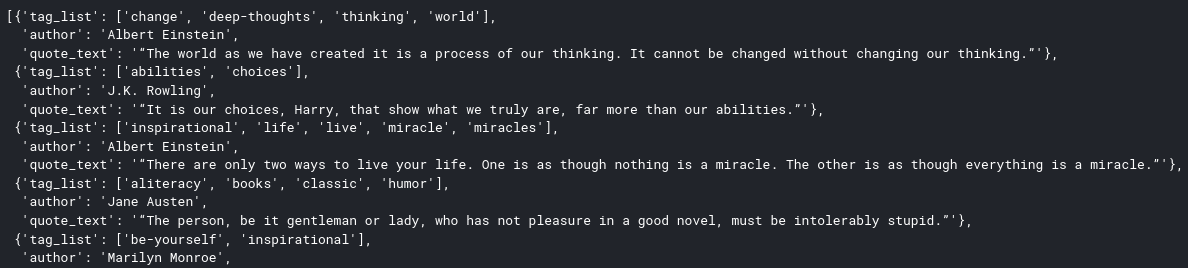

* `website` -> This is a **string** whose content is the address of the target website.
* `links` -> It consists of a **list** with all those links (hyperlinks) to **external websites**
* `timestamp` -> Is a **string** containing a timestamp of when the instance is created. An example format could be: '2021-03-29 23:45:32'

As they are read_only arguments, their content cannot be modified by the user (the program will throw an `AttributeError` when trying to assign them a value)

3. The screen representation of the `QuoteScraper` object must be of the form:

```
ScraperObject: http://quotes.toscrape.com/js/
```

4. When the object is printed in a cell, we want to display the response of the `prettify` method, built into `BeautifulSoup` (see [https://www.crummy.com/software/BeautifulSoup/bs4/doc/#pretty-printing](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#pretty-printing)), referring to the last page parsed (according to the `max_pages` argument).


*Help: Useful regex command to find patterns [] recursively ->* `(\[(?:[^][]*|(?1))*\])`

PS: Properly document the methods used. Both the conciseness in the code, as well as its readability and generality will be valued.

In [ ]:
# HERE DEFINE YOUR OWN ERROR ScraperArgumentError

"""
In all the code of this notebook, due to the variety of websites as inputs, I have taken a defensive programming approach.
Also I try to follow good coding practices.

I consider, taking into account the KISS principle, that the implemented solution related to the custom exception is too complex for this little exercise,
but I want to build a more elaborate solution to show my knowledge. 
If it was a real exercise, I would use the following custom exception and use it with custom error messages:

class ScraperArgumentError(TypeError):
    '''Raise when argument types of my scraper are wrong'''
"""


class ScraperArgumentError(TypeError):
    '''Raise when argument types of my scraper are wrong'''

    def __init__(self, arg: Optional[Any] = None, desired_type: Optional[type] = None, msg: Optional[str] = None) -> None:
        self.arg = arg
        self.desired_type = desired_type
        self.msg = msg

    def __str__(self) -> str:
        if self.msg is not None:
            return self.msg
        elif self.arg is not None and self.desired_type is not None:
            return f'must be {self.desired_type.__name__}, not {type(self.arg).__name__}'
        else:
            raise ValueError('Combination of arguments passed wrong')


def check_type(var: Any, desired_type: type) -> None:
    if type(var) is not desired_type:
        raise ScraperArgumentError(var, desired_type)

In [ ]:
# HERE DEFINE THE CLASS QuoteScraper

class QuoteScraper(BeautifulSoup):
    '''
    When accessing attributes, it returns None in case of unexpected behaviour instead of raising an exception (it could be changed depending on how this class is to be used)
    P.S.: After re-reading this code I would use exceptions instead of None, because if it cannot parse the web page the class lacks purpose, it should fail, it would be useless.
    Also due to it would not need to handle error propagation (propagate None).    '''

    def __init__(self, website: str, max_pages: Optional[int] = None) -> None:
        check_type(website, str)

        if max_pages is not None:
            check_type(max_pages, int)
            if max_pages < 1:
                raise ScraperArgumentError(
                    msg='max_pages is not greater or equal than 1'
                )

        self._website = website
        self._max_pages = max_pages

        self._timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        self.page = requests.get(website)
        # No need to create another instance
        # self.soup = BeautifulSoup(self.page.content, 'html.parser')
        super().__init__(self.page.content, 'html.parser')

        # Initialize variables first used in methods outside the constructor, for clarity
        self._quotes_list = None
        self._links = None
        self._soup_last_page_parsed = None

    def __repr__(self) -> str:
        return f'ScraperObject: {self.website}'

    def __str__(self) -> Union[str, None]:
        if self._soup_last_page_parsed is None:
            parsed_correctly = self.parse_web()
            if not parsed_correctly:
                return

        return self._soup_last_page_parsed.prettify()

    @property
    def quotes_list(self) -> Union[List[dict], None]:
        if self._quotes_list is None:
            parsed_correctly = self.parse_web()
            if not parsed_correctly:
                return

        return self._quotes_list

    @property
    def links(self) -> Union[List[str], None]:
        if self._links is None:
            parsed_correctly = self.parse_web()
            if not parsed_correctly:
                return

        return self._links

    @property
    def website(self) -> str:
        return self._website

    @property
    def timestamp(self) -> str:
        return self._timestamp

    def parse_web(self) -> Union[bool, None]:
        '''
        Due to loading a browser is expensive, we extract quotes reading its JSON text and converting it to Python objects 
        To navigate to the next pages we looking for the class 'pager' and its subclass 'next', intended to be more decoupled and fault tolerant'

        Returns None in unexpected behaviour, True otherwise
        '''

        def get_page_quotes(soup: BeautifulSoup) -> Union[List[dict], None]:
            script_tag = soup.find('script', src=None)
            if script_tag is None:
                print('Cannot find script tag', file=sys.stderr)
                return

            pattern = 'var data =(.+?);\n'
            page_raw_data = re.findall(pattern, script_tag.string, re.S)
            if page_raw_data is None:
                print('Cannot find var data in the script tag', file=sys.stderr)
                return

            page_quotes = json.loads(page_raw_data[0])

            # Rename dict keys and remove unnecessary data from author
            page_quotes = [{'tag_list': quote['tags'], 'author': quote['author']['name'], 'quote_text': quote['text']}
                           for quote in page_quotes]

            return page_quotes

        def get_external_links(soup: BeautifulSoup, exclude_url: str) -> Set[str]:
            '''
            Externals links are considered links that start with 'http' or 'www' and do not contain the domain name (netloc) of the url to exclude, i.e. the internal url
            '''
            # Built-in function in Python 3.9+
            def remove_prefix(text, prefix):
                return text[len(prefix):] if text.startswith(prefix) else text

            split_url = urlsplit(exclude_url)
            # To make the regex works as expected (edge case)
            exclude_netloc_without_prefix = remove_prefix(
                split_url.netloc, 'www.')

            external_links = set()
            # Finds all links that start with 'http' or 'www' that do not contain the current URL netloc
            external_links_regex = f'^(http|www)((?!{re.escape(exclude_netloc_without_prefix)}).)*$'
            for link in soup.find_all('a', {'href': re.compile(external_links_regex)}):
                if link['href'] is not None:
                    external_links.add(link['href'])
            return external_links

        # Variables initialization
        all_quotes = []
        all_links = set()
        n_pages_parsed = 0

        current_page = self.page
        current_soup = self

        while True:
            if (page_quotes := get_page_quotes(current_soup)) is None:
                # Propagate error
                return
            all_quotes += page_quotes
            all_links |= get_external_links(current_soup, self.website)
            n_pages_parsed += 1
            # Alternative more general for python 3.5+
            # all_quotes = [*all_quotes, *page_quotes]
            # all_links = {*all_links, *get_external_links(current_soup, self.website)}

            pager_tag = current_soup.find(class_='pager')
            if pager_tag is None:
                print('Cannot find tag with class pager', file=sys.stderr)
                return

            pager_next_tag = pager_tag.find(class_='next')
            # All pages parsed (next not found) or max pages reached
            if pager_next_tag is None or (self._max_pages is not None and n_pages_parsed >= self._max_pages):
                break

            tag_with_href = pager_next_tag.find(href=True)
            if tag_with_href is None:
                print('Cannot find tag with href attribute', file=sys.stderr)
                return

            next_page_href = tag_with_href['href']
            next_page_url = urljoin(current_page.url, next_page_href)

            # Update variables
            current_page = requests.get(next_page_url)
            current_soup = BeautifulSoup(current_page.content, 'html.parser')

        # Store list in memory to not calculate it again the following times the attribute is accessed, assuming this is the desired behaviour
        self._quotes_list = all_quotes
        self._links = list(all_links)
        self._soup_last_page_parsed = current_soup

        return True

In [ ]:
# DO NOT MODIFY THE CONTENT OF THIS CELL; SIMPLY EXECUTE IT

soup = QuoteScraper("http://quotes.toscrape.com/js/")

#2 - Statistical analysis

Create a DataFrame object, stored in a variable called `df`, from the data obtained, collected in the `quotes_list` attribute, as shown in the following image:

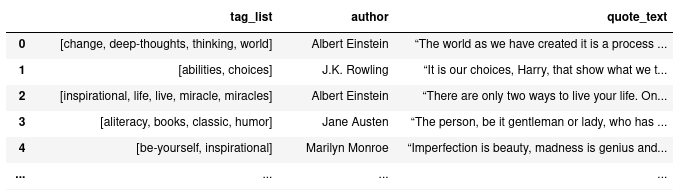

With this, answer the following questions:

1. Who is the author with the highest number of citations? and the second oldest?

2. What is the tag that appears the greatest number of times?

3. How many times does the tag "humor" appear as the only tag? (without company of others)

4. What are all the labels associated with the author Jane Austen?

In [ ]:
# INSERT CODE TO CREATE THE DATAFRAME HERE

df = pd.DataFrame(soup.quotes_list)

In [ ]:
# ANSWER TO QUESTION 1 HERE
ordered_cited_authors = df.author.value_counts().index.tolist()

print(f'Most cited author: {ordered_cited_authors[0]}')
print(f'Second most cited author: {ordered_cited_authors[1]}')

Most cited author: Albert Einstein
Second most cited author: J.K. Rowling


In [ ]:
# ANSWER TO QUESTION 2 HERE
all_tags_iter = itertools.chain.from_iterable(df.tag_list.values)

counter = Counter(all_tags_iter)
counter.most_common(1)[0][0]

'love'

In [ ]:
# ANSWER TO QUESTION 3 HERE
tag_list_desired = ['humor']
desired_serie = df.tag_list[df.tag_list.apply(lambda x: x == tag_list_desired)]

len(desired_serie)

3

In [ ]:
# ANSWER TO QUESTION 4 HERE
jane_tags_serie = df.tag_list.where(df.author == 'Jane Austen').dropna()

jane_tags_iter = itertools.chain.from_iterable(jane_tags_serie)
set(jane_tags_iter)

{'aliteracy',
 'books',
 'classic',
 'elizabeth-bennet',
 'friendship',
 'humor',
 'jane-austen',
 'library',
 'love',
 'reading',
 'romantic',
 'women'}

# Test

Run this code to see if the implemented algorithms are correct

In [ ]:
import unittest


class TestChallenge(unittest.TestCase):
    """ Test challenge """

    longMessage = False

    def setUp(self):

        self.test1 = QuoteScraper("http://quotes.toscrape.com/js/")
        self.test2 = QuoteScraper(
            "http://quotes.toscrape.com/js/", max_pages=2)

    def test_class_incorrect_types(self):
        """ Correct type testing """

        test1 = self.test1
        test2 = self.test2

        # error checking

        self.assertRaises(AttributeError, lambda: test1.__setattr__(
            "timestamp", "2020-04-01 21:00:00"))
        self.assertRaises(AttributeError, lambda: test1.__setattr__(
            "website", "www.collis.io"))
        self.assertRaises(AttributeError, lambda: test1.__setattr__(
            "quotes_list", [1, 2, 3]))

        self.assertRaises(ScraperArgumentError, lambda: QuoteScraper(
            "http://quotes.toscrape.com/js/", max_pages="2"))
        self.assertRaises(ScraperArgumentError, lambda: QuoteScraper(
            "http://quotes.toscrape.com/js/", max_pages=-2))
        self.assertRaises(ScraperArgumentError, lambda: QuoteScraper(
            "http://quotes.toscrape.com/js/", max_pages=1.5))

        self.assertRaises(ScraperArgumentError, lambda: QuoteScraper(1.5))
        self.assertRaises(ScraperArgumentError, lambda: QuoteScraper({1, 2}))
        self.assertRaises(ScraperArgumentError, lambda: QuoteScraper([1, 2]))

        # type checking

        self.assertEqual(type(test1.links), list)
        self.assertEqual(type(test1.quotes_list), list)
        self.assertEqual(type(test1.website), str)

    def test_class_values(self):
        """ Testing of correct values """

        test1 = self.test1
        test2 = self.test2

        self.assertEqual(
            sha256(json.dumps(test1.quotes_list,
                   sort_keys=True).encode()).hexdigest(),
            '16719270eaabdb39ca3b0a6bceed0bf61d3cf189923b5bf3cce4357795ea2fed',
            "Error en la comprobación del valor del atributo quotes_list"
        )

        self.assertEqual(
            sha256(json.dumps(test2.quotes_list,
                   sort_keys=True).encode()).hexdigest(),
            '2d456ef71876ab2cbc7299750339cea43d2ee92302894c85401812e55a0e6fa1',
            "Error en la comprobación del valor del atributo quotes_list"
        )

        self.assertEqual(
            sha256(test1.website.encode()).hexdigest(),
            'e8d49800defc93e651b96c04b7e8b45e93e7b657e704f9173f92a64d5d720c16',
            "Error en la comprobación del valor del atributo website"
        )

        self.assertEqual(
            sha256(test1.__repr__().encode()).hexdigest(),
            '8f37dddeb4d6c5e2e1a973dada4833ef76fc06acb14c9b26d5af76798bc44e01',
            "Error en la comprobación de la representación del objeto"
        )

        self.assertEqual(
            sha256(test2.__str__().encode()).hexdigest(),
            'fa41d3d6cd3c8e0465c219c6c156ee9f4f715701937d6784e44a50f4ed0f7fae',
            "Error en la comprobación de la visualización del objeto"
        )

    def test_dataframe(self):

        test_df = df

        self.assertEqual(
            df.quote_text.apply(lambda x: int(
                sha256(x.encode()).hexdigest(), 16)).sum(),
            6139350500913917410435933794909997871105939780438632800039839790887495754545995,
            "Error en la comprobación del DataFrame"
        )


if __name__ == '__main__':

    unittest.main(argv=[''], exit=False, verbosity=2)

test_class_incorrect_types (__main__.TestChallenge)
Testeo de tipos correctos ... ok
test_class_values (__main__.TestChallenge)
Testeo de valores correctos ... ok
test_dataframe (__main__.TestChallenge) ... ok

----------------------------------------------------------------------
Ran 3 tests in 7.006s

OK
